<a href="https://colab.research.google.com/github/mikearnaldi/options/blob/main/Options_Analisys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yahooquery
!pip install opstrat

import yahooquery as yq
import pandas as pd
import matplotlib.pyplot as plt
import opstrat as op
from datetime import datetime

     |████████████████████████████████| 46 kB 2.0 MB/s 
     |████████████████████████████████| 6.3 MB 10.1 MB/s 
  Created wheel for requests-futures: filename=requests_futures-1.0.0-py3-none-any.whl size=7029 sha256=1ba6601e5e7a4cfc383882ccfa88e4355309e393b727beaec75b476ffa7b5b81
  Stored in directory: /root/.cache/pip/wheels/e6/5d/70/8aa32975ceceb612d545b74897e6e8dcc399d78522458c3004
Successfully built requests-futures
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=2f16841875e218024f27058c73839926bb14206174e6826e7043a1fae6eb9ec6
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance


In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



Instrument: SPY (min: 308.98 max: 573.82 act: 441.4)

Open delta



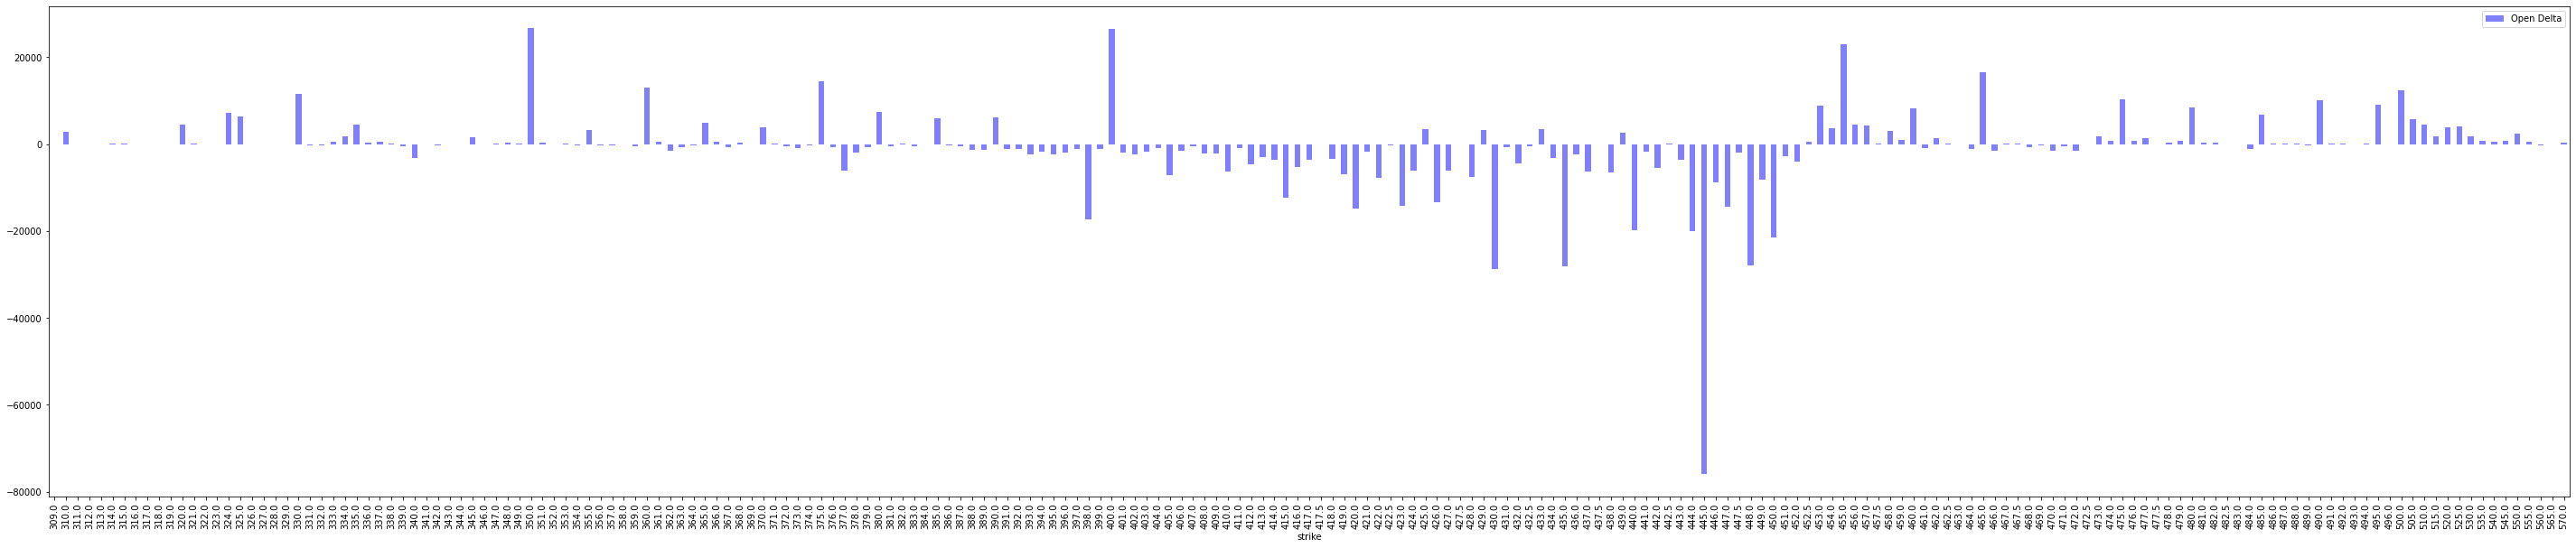



Open gamma



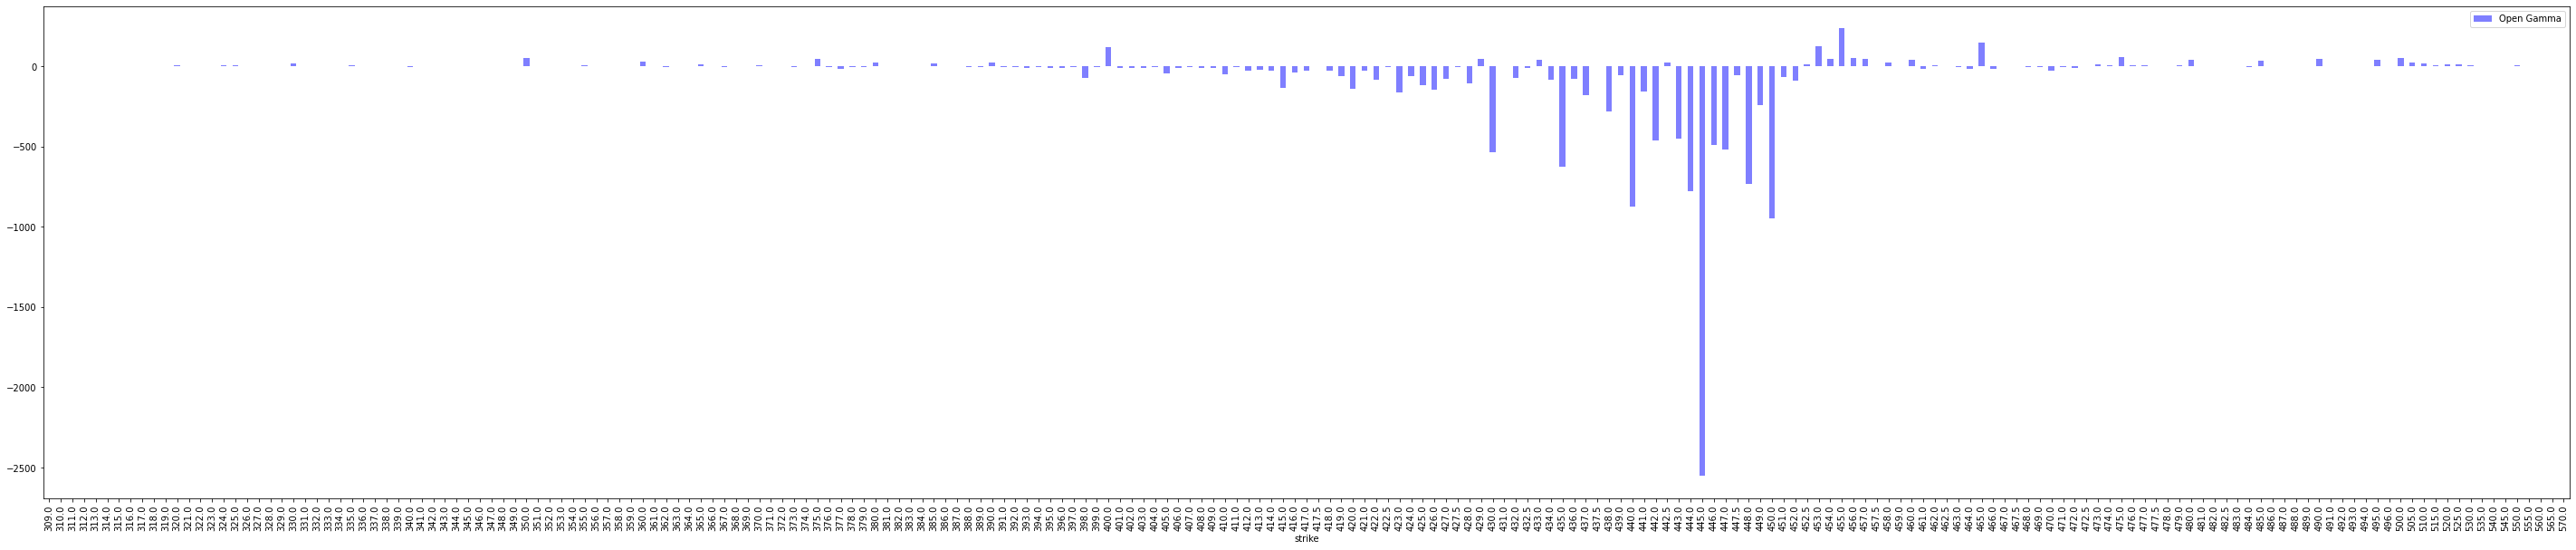





Instrument: QQQ (min: 261.68 max: 485.98 act: 373.83)

Open delta



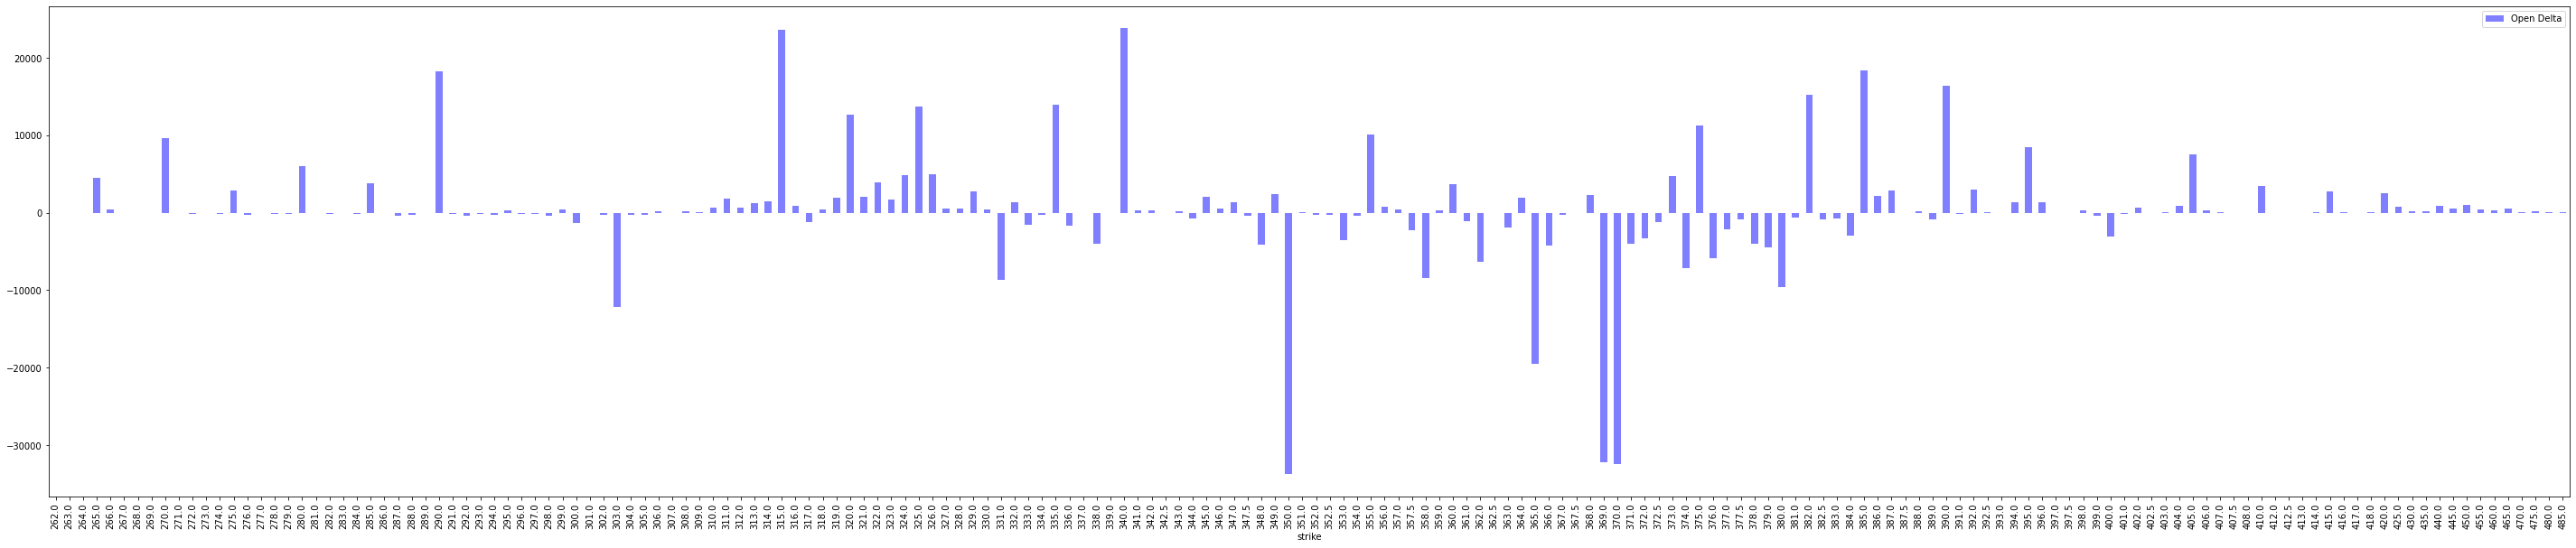



Open gamma



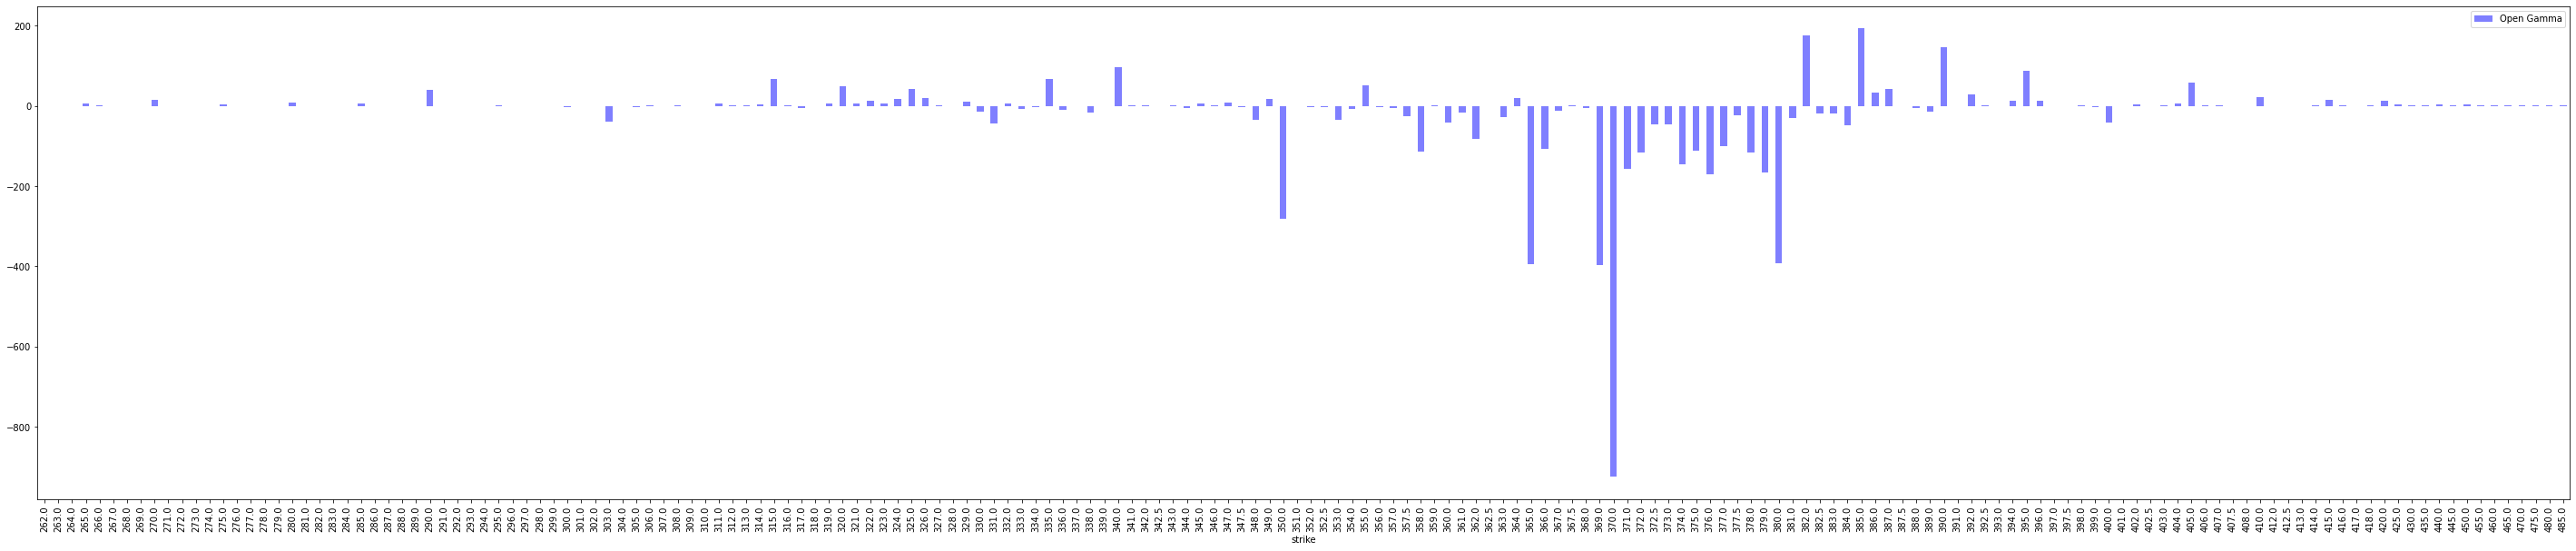





Instrument: TSLA (min: 531.64 max: 987.34 act: 759.49)

Open delta



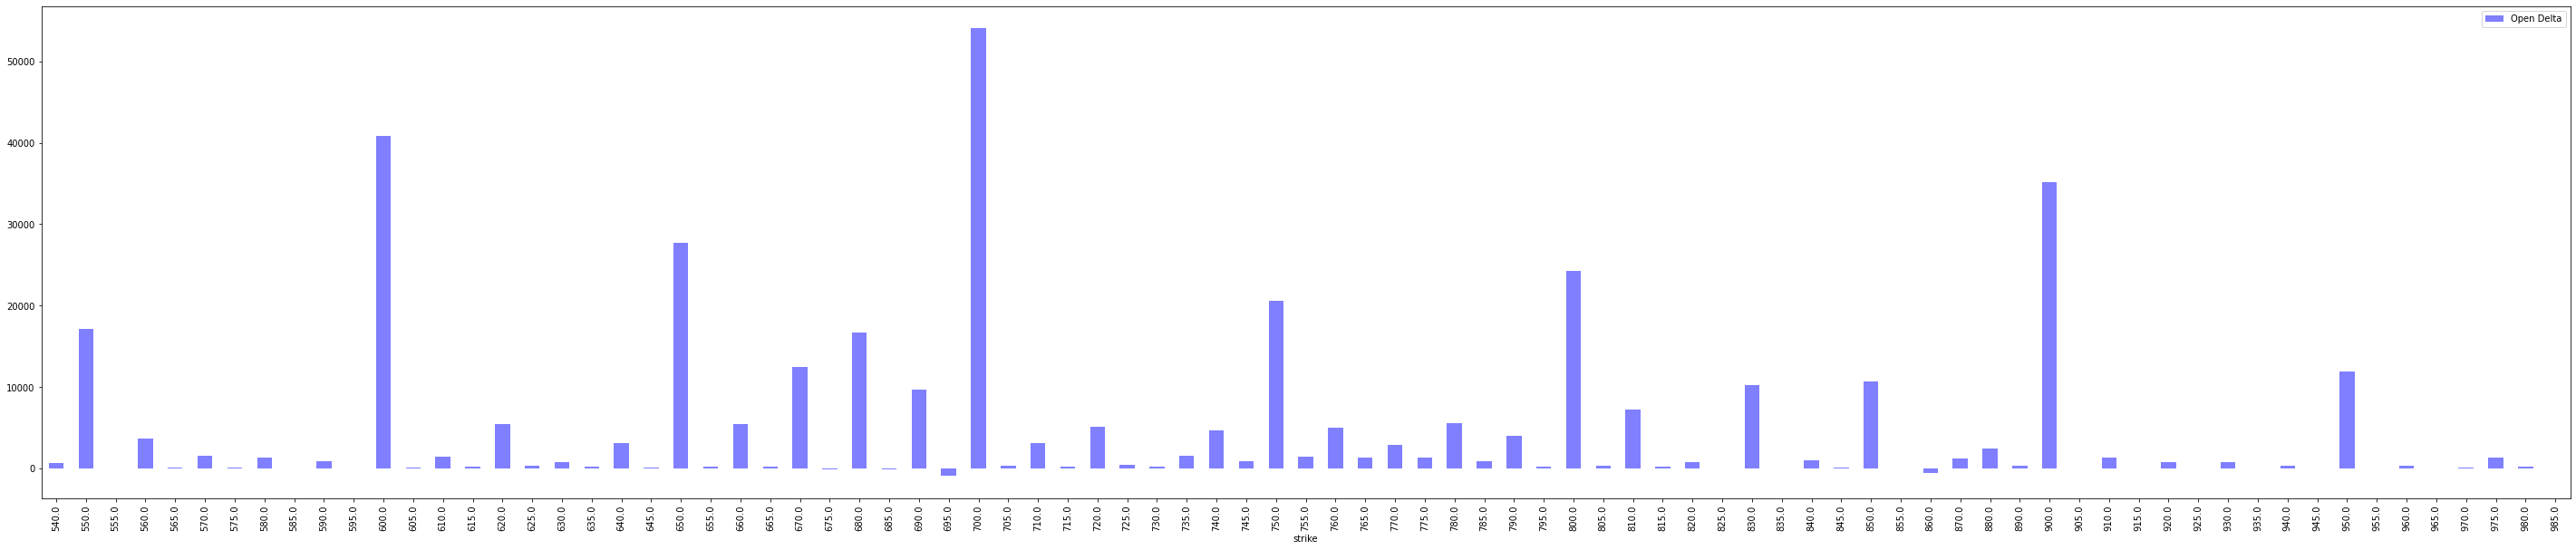



Open gamma



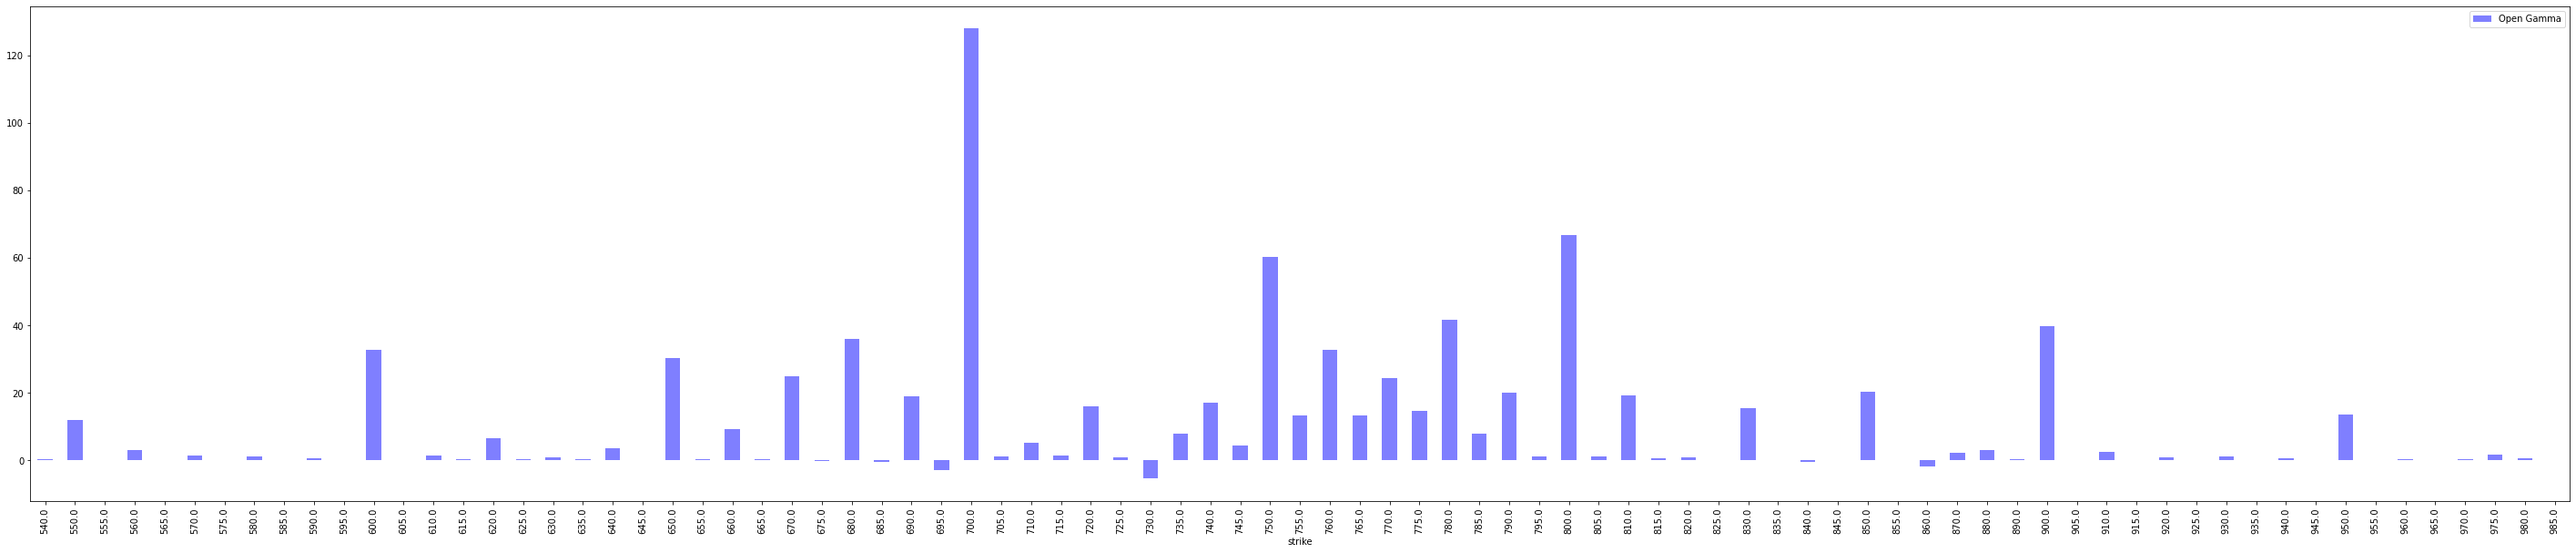

In [ ]:
## config

today = "2021-09-19"

expiry_detailed = False

options = [
  { 
    "symbol": "SPY", 
    "move": 0.30,
    "expiries": [
      { "date": '2021-09-20', "kind": "W" },
      { "date": '2021-09-22', "kind": "W" },
      { "date": '2021-09-24', "kind": "W" },
      { "date": '2021-09-27', "kind": "W" },
      { "date": '2021-09-29', "kind": "W" },
      { "date": '2021-09-30', "kind": "W" },
      { "date": '2021-10-01', "kind": "W" },
      { "date": '2021-10-04', "kind": "W" },
      { "date": '2021-10-06', "kind": "W" },
      { "date": '2021-10-08', "kind": "W" },
      { "date": '2021-10-11', "kind": "W" },
      { "date": '2021-10-13', "kind": "W" },
      { "date": '2021-10-15', "kind": "M" }
    ]
  },
  { 
    "symbol": "QQQ", 
    "move": 0.30,
    "expiries": [
      { "date": '2021-09-20', "kind": "W" },
      { "date": '2021-09-22', "kind": "W" },
      { "date": '2021-09-24', "kind": "W" },
      { "date": '2021-09-27', "kind": "W" },
      { "date": '2021-09-29', "kind": "W" },
      { "date": '2021-09-30', "kind": "W" },
      { "date": '2021-10-01', "kind": "W" },
      { "date": '2021-10-04', "kind": "W" },
      { "date": '2021-10-06', "kind": "W" },
      { "date": '2021-10-08', "kind": "W" },
      { "date": '2021-10-11', "kind": "W" },
      { "date": '2021-10-13', "kind": "W" },
      { "date": '2021-10-15', "kind": "M" }
    ]
  },
  { 
    "symbol": "TSLA", 
    "move": 0.30,
    "expiries": [
      { "date": '2021-09-24', "kind": "W" },
      { "date": '2021-10-01', "kind": "W" },
      { "date": '2021-10-08', "kind": "W" },
      { "date": '2021-10-15', "kind": "M" }
    ]
  },
]


## program

figsize = (50,10)

for instrument in options:
  symbol = instrument["symbol"]
  ticker = yq.Ticker([symbol], asynchronous=True)
  price = ticker.price[symbol]["regularMarketPrice"]
  date_format = "%Y-%m-%d"
  today_time = datetime.strptime(today, date_format)
  
  move = instrument["move"]
  max = round(price * (1 + move), 2)
  min = round(price * (1 - move), 2)

  print("\n")
  
  print(f"Instrument: {symbol} (min: {min} max: {max} act: {price})\n")
  
  df = ticker.option_chain
  df = df[df['strike'] >= min]
  df = df[df['strike'] <= max]

  def calc_price(row):
    date = row.name[1]
    delta = date - today_time
    daysToExpiry = delta.days
    bsm = op.black_scholes(K=row["strike"], St=price, r=0.09, t=daysToExpiry, v=row["impliedVolatility"]*100, type="c" if row.name[2] == "calls" else "p")
    return bsm["value"]["option value"], bsm["value"]["intrinsic value"], bsm["value"]["time value"], bsm["greeks"]["delta"], bsm["greeks"]["gamma"], bsm["greeks"]["theta"], bsm["greeks"]["vega"], bsm["greeks"]["rho"]
  
  df[['value', 'intrinsic_value', 'time_value', 'delta', 'gamma', 'theta', 'vega', 'rho']] = df.apply(calc_price, axis=1, result_type="expand")

  df['open_delta'] = df['openInterest'] * df['delta']
  df['open_gamma'] = df['openInterest'] * df['delta'] * df['gamma']

  open_delta = df[['strike', 'open_delta']].groupby("strike").sum()
  open_delta['strike'] = open_delta.index

  print("Open delta\n")

  ax = plt.gca()
  open_delta.plot(kind='bar', x='strike', y='open_delta', ax=ax, color='blue', alpha=0.5, figsize=figsize, label='Open Delta')
  plt.show()

  print("\n")
  
  open_gamma = df[['strike', 'open_gamma']].groupby("strike").sum()
  open_gamma['strike'] = open_gamma.index

  print("Open gamma\n")

  ax = plt.gca()
  open_gamma.plot(kind='bar', x='strike', y='open_gamma', ax=ax, color='blue', alpha=0.5, figsize=figsize, label='Open Gamma')
  plt.show()

  print("\n")

  if expiry_detailed:
    for expiry in instrument["expiries"]:
      date = expiry["date"]
      kind = expiry["kind"]
      
      delta = datetime.strptime(date, date_format) - today_time
      daysToExpiry = delta.days

      o_calls = df.loc[symbol, date, 'calls']
      o_puts = df.loc[symbol, date, 'puts']

      print(f"Contracts expiring in {daysToExpiry} days ({date})")
      print("\n")
      print(o_calls[["strike", "value", "intrinsic_value", "time_value", "delta", "gamma", "theta"]])
      print("\n")
      print(o_puts[["strike", "value", "intrinsic_value", "time_value", "delta", "gamma", "theta"]])
      print("\n")

      calls = o_calls[['strike', 'openInterest']]
      puts = o_puts[['strike', 'openInterest']]
      all_puts = puts.loc[:, ['strike', 'openInterest']]
      all_puts['openInterest'] = -1 * all_puts['openInterest']
      net = calls.append(all_puts)
      all = calls.append(puts)
      net_cp = net.groupby('strike').sum()
      all_cp = all.groupby('strike').sum()
      net_cp['strike'] = net_cp.index
      all_cp['strike'] = all_cp.index

      print("Net Call-Put\n")

      ax = plt.gca()
      net_cp.plot(kind='bar', x='strike', y='openInterest', ax=ax, color='blue', alpha=0.5, figsize=figsize, label='CALL-PUT')
      all_cp.plot(kind='bar', x='strike', y='openInterest', ax=ax, color='green', alpha=0.2, figsize=figsize, label='CALL+PUT')
      plt.show()

      print("Calls\n")

      ax = plt.gca()
      calls.plot(kind='bar', x='strike', y='openInterest', ax=ax, color='green', figsize=figsize, label='Calls')
      plt.show()

      print("Puts\n")

      ax = plt.gca()
      puts.plot(kind='bar', x='strike', y='openInterest', ax=ax, color='red', figsize=figsize, label='Puts')
      plt.show()